# Face Recognition

In [32]:
import cv2
import face_recognition
import keras
import joblib
import numpy as np
import os
import pickle
import sklearn
import matplotlib
from google_images_download import google_images_download
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance
from time import time
from tqdm import tqdm

from keras.preprocessing import image as kimage
from keras.applications import inception_v3
from keras.applications.inception_v3 import preprocess_input
from skimage import feature

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

<font size=3>

La funzione ``load_data`` carica tutte le immagini delle cartelle specificate. <br>I parametri in ingresso sono:
* <b>feature_extractor</b>: metodo per estrarre le feature più rilevanti dalle immagini caricate.
* <b>base_path</b>: percorso da cui prendere le immagini
* <b>face_rec</b>: questo parametro booleano serve per effettuare un riconoscimento facciale delle immagini caricate.
* <b>maximages</b>: massimo numero di immagini da caricare
* <b>prep</b>: valore booleano per indicare se effettuare del preprocessing sulle immagini
<br></br>

Con la funzione ``face_locations`` si ritaglia l'immagine in modo da ricavare solamente il volto della persona di interesse. <br> In alcune immagini, dato che era stato preso il profilo della persona, l'algoritmo non era in grado di riconoscere alcun volto: in questi casi si procede senza effettuare il crop.
<br></br>
Il preprocessing delle immagini, se necessario, è effettuato mediante la funzione ``bilateralFilter``. Questa funzione, dato in input un valore del filtro e la matrice su cui applicarlo, restituisce un'immagine sfocata. Questa soluzione, all'apparenza controversa, risulta essere efficace in diversi contesti: viene infatti rimosso del rumore strutturale legato allo strumento di acquisizione dell'immagine. [Esempio (slide 4)](https://people.csail.mit.edu/sparis/bf_course/slides/04_applications_simple_bf.pdf)<br>
Le immagini sono ridimensionate in base al formato richiesto dalla rete neurale che sarà utilizzata per estrarre le features, e i risultati sono salvati in set di train e test come per il primo punto del progetto.

In [40]:
def load_data(feature_extractor, base_path, face_rec=True, maximages=82, prep=True):
    labels = []
    features = []
    
    for di, d in enumerate(sorted(os.listdir(base_path))):
        for fi, f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            
            if f.endswith('.jpg') and fi < maximages:
                try:
                    image = face_recognition.load_image_file(base_path + d + '/' + f)
                    if face_rec: # face recognition
                        face_locations = face_recognition.face_locations(image)
                        
                        if len(face_locations) == 1:          
                            top, right, bottom, left = face_locations[0]
                            image = image[top:bottom, left:right]
                        if len(face_locations) == 0:
                            pass
                        
                        """
                        Questa condizione si può verificare per il secondo task di classificazione che verrà
                        presentato più avanti nel notebook. Nel caso si risconoscano più volti si salterà tutta
                        la procedura e si passa alla successiva iterazione.
                        """
                        if len(face_locations) > 2:
                            continue
                        
                        image = np.array(image)
                        if prep:
                            image = cv2.bilateralFilter(image, 9, 20, 20)
                        
                    image = cv2.resize(image, dsize=(299, 299))
                    
                    cur_features = feature_extractor(image)
                    features.append(cur_features)
                    labels.append(di)
                        
                except OSError:
                    pass
                
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=1,
                                                        stratify=labels)
    

        
    return X_train, X_test, y_train, y_test

In [15]:
def nn_inception(img):
    x = kimage.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_v3.preprocess_input(x)
    f = nn.predict(x)
    return f.flatten()

In [14]:
nn = inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling='max')

In [16]:
def matrix(prediction, tests, names):
    # New colormap
    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "lightyellow"],
              [norm(-0.95), "antiquewhite"],
              [norm(-0.8), "wheat"],
              [norm(-0.3), "navajowhite"],
              [norm( 0.3), "orange"],
              [norm( 0.8), "tomato"],
              [norm( 0.9), "red"],
              [norm( 1.0), "darkred"]]

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
    
    print(classification_report(tests, prediction)) 
    
    print("Accuracy: " + str(round(accuracy_score(tests, prediction), 3)) + "\n")
    cm = confusion_matrix(tests, prediction)
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis] # Trasforma i valori in percentuale
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    fig.colorbar(cax)

    plt.title('Confusion matrix', pad=40)
    
    # Viene forzata la visualizzazione di tutte le label
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(names)))
    ax.set_xticklabels(names, rotation=35)
    ax.set_yticklabels(names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Riconoscimento senza preprocessing

<font size=3>

Il primo task di classificazione consiste nel riconoscere il volto dei componenti del gruppo senza effettuare il preprocessing (viene fatto solo il crop). 
<br></br>
 I file sono caricati e passati alla funzione di estrazione delle feature, in questo caso la rete neurale <b>InceptionV3</b>. 
<br></br>
I valori vengono normalizzati; si salvano i vettori in modo da non dover effettuare il loading ogni volta. Viene poi creato un modello di classificazione <b>SVM</b> con tuning sui parametri C e gamma.

In [49]:
base_path = './rullino/'

X_train, X_test, y_train, y_test = load_data(feature_extractor=nn_inception, base_path=base_path, 
                                             face_rec=True, prep=False)

In [50]:
X_train_stack = np.array([])
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))
    
eps = 0.001
X_train_mean = X_train_stack.mean()
X_train_std = X_train_stack.std()
X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]

In [36]:
np.save('face0F_Xtrain.npy', X_train)
np.save('face0F_Xtest.npy', X_test)
np.save('face0F_X_train_mean.npy', X_train_mean)
np.save('face0F_X_train_std.npy', X_train_std)

with open('face0F_ytrain', 'wb') as yte:
    pickle.dump(y_train, yte)
with open('face0F_ytest', 'wb') as ytr:
    pickle.dump(y_test, ytr)

In [2]:
X_train = np.load('face0_Xtrain_prepF.npy')
X_test = np.load('face0_Xtest_prepF.npy')

with open('face0_ytrain_prepF', 'rb') as yte:
    y_train = pickle.load(yte)
with open('face0_ytest_prepF', 'rb') as ytr:
    y_test = pickle.load(ytr)

In [51]:
param_grid = {'C': [1, 5, 10],
              'gamma': [0.001, 0.005, 0.01]} 

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=1)

t1 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t1))

print("Migliore combinazione di parametri:")
print(" C: " + str(clf.best_estimator_.C))
print(" gamma: " + str(clf.best_estimator_.gamma))

c:\users\prowm\anaconda3\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 1.671s
Migliore combinazione di parametri:
 C: 5
 gamma: 0.005


In [53]:
from joblib import dump, load
dump(clf, 'SVCface1.joblib')

['SVCface1.joblib']

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.93      0.82      0.87        17

   micro avg       0.88      0.88      0.88        33
   macro avg       0.88      0.88      0.88        33
weighted avg       0.88      0.88      0.88        33

Accuracy: 0.879

[[15  1]
 [ 3 14]]


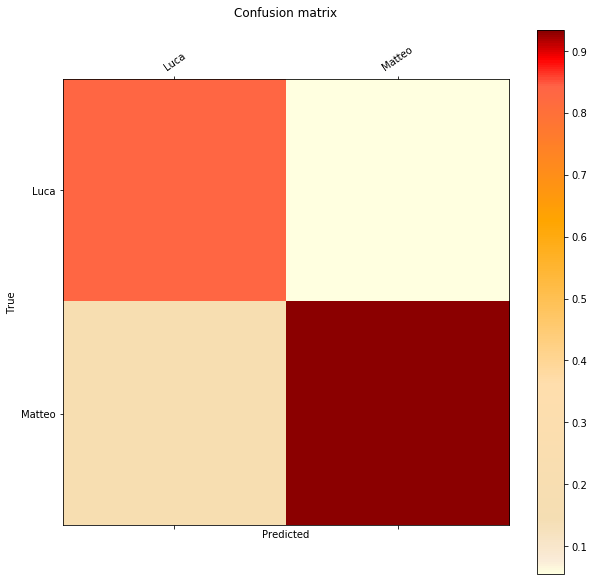

In [52]:
y_pred = clf.predict(X_test)

nomi = ["Luca", "Matteo"]
l = list(np.unique(y_train))
for i in range(len(nomi)):
    l[i] = nomi[i]
    
matrix(prediction=y_pred, tests=y_test, names=nomi)

<font size=3>

La classificazione raggiunge valori di $0.879$ per accuratezza e f1-score, che sono sostanzialmente superiori al random guess, ma allo stesso tempo relativamente bassi per un classificatore che deve identificare solamente due classi.

## Riconoscimento con preprocessing

<font size=3>

Al fine di migliorare le performance classificative viene applicato un preprocessing alle immagini secondo la funzione descritta in precedenza.<br>

In [ ]:
base_path = './rullino/'

X_train, X_test, y_train, y_test = load_data(feature_extractor=nn_inception, base_path=base_path, 
                                             face_rec=True, prep=True)

In [13]:
X_train_stack = np.array([])
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))
    
eps = 0.001
X_train_mean = X_train_stack.mean()
X_train_std = X_train_stack.std()
X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]

In [14]:
np.save('face0_Xtrain_prepT.npy', X_train)
np.save('face0_Xtest_prepT.npy', X_test)

with open('face0_ytrain_prepT', 'wb') as yte:
    pickle.dump(y_train, yte)
with open('face0_ytest_prepT', 'wb') as ytr:
    pickle.dump(y_test, ytr)

In [8]:
X_train = np.load('face0_Xtrain_prepT.npy')
X_test = np.load('face0_Xtest_prepT.npy')

with open('face0_ytrain_prepT', 'rb') as yte:
    y_train = pickle.load(yte)
with open('face0_ytest_prepT', 'rb') as ytr:
    y_test = pickle.load(ytr)

In [9]:
param_grid = {'C': [1, 5, 10],
              'gamma': [0.001, 0.005, 0.01]} 

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=1)

t1 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t1))

print("Migliore combinazione di parametri:")
print(" C: " + str(clf.best_estimator_.C))
print(" gamma: " + str(clf.best_estimator_.gamma))

c:\users\prowm\anaconda3\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 3.310s
Migliore combinazione di parametri:
 C: 5
 gamma: 0.005


In [13]:
dump(clf, 'SVCface1.joblib')

['SVCface1.joblib']

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.94      1.00      0.97        17

   micro avg       0.97      0.97      0.97        33
   macro avg       0.97      0.97      0.97        33
weighted avg       0.97      0.97      0.97        33

Accuracy: 0.97

[[15  1]
 [ 0 17]]


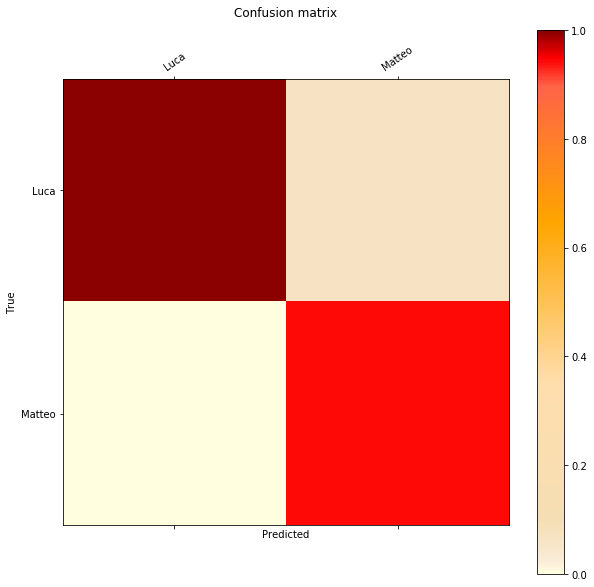

In [10]:
y_pred = clf.predict(X_test)
    
matrix(prediction=y_pred, tests=y_test, names=nomi)

<font size=3>
    
Il modello raggiunge un'accuratezza di $0.97$, un netto miglioramento rispetto alla classificazione precedente; solamente un'immagine viene classificata erroneamente. 

# Riconoscimento immagini da Google

## Riconoscimento senza preprocessing

<font size=3>
    
Nel task di classificazione precedente sono state volutamente aggiunte alcune complicazioni:
* Alcune foto sono state scattate di profilo (in questa condizione ``face_locations`` fatica a fare un crop del volto).
* I componenti del gruppo hanno fatto foto sia con che senza occhiali.
* Le condizioni di luce, pur non essendo pessime, variavano a seconda dell'immagine.
<br></br>

Si è voluto replicare l'algoritmo su un task di classificazione ancora più complicato, riguardante immagini di diverse figure politiche internazionali, prese direttamente da Google.

<font size=3>
    
La funzione <i>downloadimages</i> permette di scaricare le immagini in base a una query user-based. L'utente ha la possibilità di specificare diversi parametri per la ricerca:
* <b>query</b>: parole chiave da ricercare
* <b>format</b>: formato dell'immagine (per semplicità si scaricheranno solamente immagini in .jpg, lo stesso formato utilizzato per il primo task)
* <b>limit</b>: numero di immagini da scaricare. Questa quantità è fissa per tutti i personaggi, ma l'algoritmo in alcuni casi non riesce a scaricare l'immagine; è quindi possibile che la numerosità non sia la stessa per tutte le classi.
* <b>print_urls</b>: valore booleano, se vero viene stampato a video il link dell'immagine scaricata
* <b>size</b>: dimensione dell'immagine da scaricare.
* <b>type of image</b>: tipologia di immagine da ricercare, nel nostro caso volti di persone
* <b>aspect_ratio</b>: proporzioni fra i due assi dell'immagine.
<br></br>

Questa funzione fa riferimento alla ricerca avanzata che Google mette a disposizione, effettuabile a questo [link](https://www.google.com/advanced_image_search).
<br></br>
La documentazione relativa alla funzione è consultabile su [Github](https://github.com/hardikvasa/google-images-download/blob/master/google_images_download/google_images_download.py).

In [19]:
response = google_images_download.googleimagesdownload()

def downloadimages(query):
    arguments = {"keywords": query, 
                 "format": "jpg", 
                 "limit": 80, 
                 "print_urls": False, 
                 "size": ">400*300", 
                 "type of image": "face",
                 "aspect_ratio:": "square"}
    
    try: 
        response.download(arguments)     
    except FileNotFoundError:  
        arguments = {"keywords": query, 
                     "format": "jpg", 
                     "limit": 80, 
                     "print_urls": False,  
                     "type of image": "face",
                     "size": "medium"}

        try: 
            response.download(arguments) # Downloading the photos based on the given arguments 
        except: 
            pass
        
        
search_queries = ["Angela Merkel", "Donald Trump", "Giuseppe Conte", "Ursula von der Leyen", "Xi Jinping"]

<font size=3>
    
Sono stati scelti i seguenti politici: Angela Merkel, Donald Trump, Giuseppe Conte, Ursula von der Leyen e Xi Jinping. <br> E' stato necessario aggiungere anche il termine <i>face</i> nella ricerca in quanto i risultati il più delle volte non era totalmente pertinenti.

In [86]:
# Driver Code 
for query in search_queries: 
    downloadimages(query + " face")  
    print()  


Item no.: 1 --> Item name = Angela Merkel face
Evaluating...
Starting Download...
Completed Image ====> 1.Angela-Merkel.jpg
Completed Image ====> 2.AngelaM2.jpg
Wrong image format returned. Skipping...
Completed Image ====> 3.GettyImages-865297138-714x476.jpg
Completed Image ====> 4.angela_merkel.jpg
Completed Image ====> 5.Angela-Merkel-735558.jpg
Completed Image ====> 6.GettyImages-478972608-714x476.jpg
Completed Image ====> 7.55a6e63a3e131.jpg
Completed Image ====> 8.methode%2Ftimes%2Fprod%2Fweb%2Fbin%2F249b6d4c-1b0e-11e8-9010-1eef6ba5d3de.jpg
Completed Image ====> 9.61PGqOoB4fL._SX425_.jpg
Completed Image ====> 10.Angela-Merkel-German-Chancellor-Card-Party-Face-Mask-available-now-at-starstills__03440.1474903717.jpg
Completed Image ====> 11.angela-merkel-crisis-coalition-migration.jpg
Completed Image ====> 12.Angela-Merkel-with-a-Small-Face--127108.jpg
Completed Image ====> 13.AP18285452277982.jpg
Completed Image ====> 14.merkel-angela.jpg
Wrong image format returned. Skipping...
C

Completed Image ====> 72.1560783182-lapresse-20190617160217-29669561.jpg
Completed Image ====> 73.il-presidente-degli-stati-uniti-trump-tiene-una-conferenza-stampa-congiunta-con-il-primo-ministro-giuseppe-conte-di-italia-nella-sala-est-della-casa-bianca-di-washington-dc-il-lunedi-30-luglio-2018-credito-ron-sachscnp-mediapunch-pbwk71.jpg
Completed Image ====> 74.7b8d3e2843ee1738b5abcc22bd73b1a6.jpg
Completed Image ====> 75.giuseppe-conte.jpg
Completed Image ====> 76._107223554_hi054409069.jpg
Completed Image ====> 77.d63785b5-082c-43b8-a7bb-de181a23d3cf_xl.jpg
Wrong image format returned. Skipping...
Completed Image ====> 78.42631453651_fa1c83af22_b.jpg
Completed Image ====> 79.1535464805655.jpg
Completed Image ====> 80.d6e91684d4f3695f1be54be296a2b420d02dd002.jpg

Errors: 10



Item no.: 1 --> Item name = Ursula von der Leyen face
Evaluating...
Starting Download...
Completed Image ====> 1.von-der-leyen-310.jpg
Wrong image format returned. Skipping...
Wrong image format returned. Skippi

<font size=3>
    
Una volta runnato l'algoritmo viene creata nella directory di riferimento una cartella chiamata download con all'interno tante cartelle quante sono le query da effettuare.
<br></br>
Prima di caricare le immagini secondo la classica procedura si è provveduto ad effettuare manualmente un controllo dei file scaricati. Uno dei problemi principali sono state le immagini in cui il personaggio era presente insieme ad un'altra persona; queste foto sono scartate di default dall'algoritmo di caricamento.<br> Alcune immagini sono state eliminate manualmente in quanto il volto della persona scaricata non era quello della persona ricercata.
<br></br>

Per questo task sono da tenere conto anche le seguenti complicazioni:
* Le immagini scaricate possono riferirsi a periodi temporali diversi, in cui il volto della persona può aver subito delle modifiche fisiologiche.
* Come già accennato in precedenza, si è specificato di prendere delle immagini che rappresentassero il volto della persona. Tuttavia l'algoritmo non era sempre preciso; ci sono quindi delle foto dell'intera persona, in alcuni casi presa anche da lontano.
* Spesso vengono scaricate delle caricature dei volti originali.
<br></br>

I passaggi successivi sono gli stessi dei task precedenti con la normalizzazione, il salvataggio degli oggetti creati ed una ricerca dei parametri ottimali della SVM tramite grid search.

In [57]:
base_path = './downloads/'

X_train, X_test, y_train, y_test = load_data(feature_extractor=nn_inception, base_path=base_path, face_rec=True,
                                             prep=True)


X_train_stack = np.array([])
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))
    
eps = 0.001
X_train_mean = X_train_stack.mean()
X_train_std = X_train_stack.std()
X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]

In [58]:
np.save('face1F_Xtrain_prep.npy', X_train)
np.save('face1F_Xtest_prep.npy', X_test)
np.save('face1F_X_train_mean.npy', X_train_mean)
np.save('face1F_X_train_std.npy', X_train_std)

with open('face1_ytrain_prepF', 'wb') as yte:
    pickle.dump(y_train, yte)
with open('face1_ytest_prepF', 'wb') as ytr:
    pickle.dump(y_test, ytr)

In [20]:
X_train = np.load('face1_Xtrain_prepF.npy')
X_test = np.load('face1_Xtest_prepF.npy')

with open('face1_ytrain_prepF', 'rb') as yte:
    y_train = pickle.load(yte)
with open('face1_ytest_prepF', 'rb') as ytr:
    y_test = pickle.load(ytr)

In [56]:
param_grid = {'C': [100, 120, 150],
              'gamma': [0.0001, 0.005]} 

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=-1)

t1 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t1))

print("Migliore combinazione di parametri:")
print(" C: " + str(clf.best_estimator_.C))
print(" gamma: " + str(clf.best_estimator_.gamma))

c:\users\prowm\anaconda3\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 3.695s
Migliore combinazione di parametri:
 C: 120
 gamma: 0.0001


              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.60      0.50      0.55        12
           2       0.50      0.75      0.60        12
           3       0.50      0.42      0.45        12
           4       0.40      0.22      0.29         9

   micro avg       0.58      0.58      0.58        60
   macro avg       0.55      0.55      0.54        60
weighted avg       0.57      0.58      0.57        60

Accuracy: 0.583

[[13  1  0  1  0]
 [ 2  6  2  1  1]
 [ 0  0  9  2  1]
 [ 1  2  3  5  1]
 [ 1  1  4  1  2]]


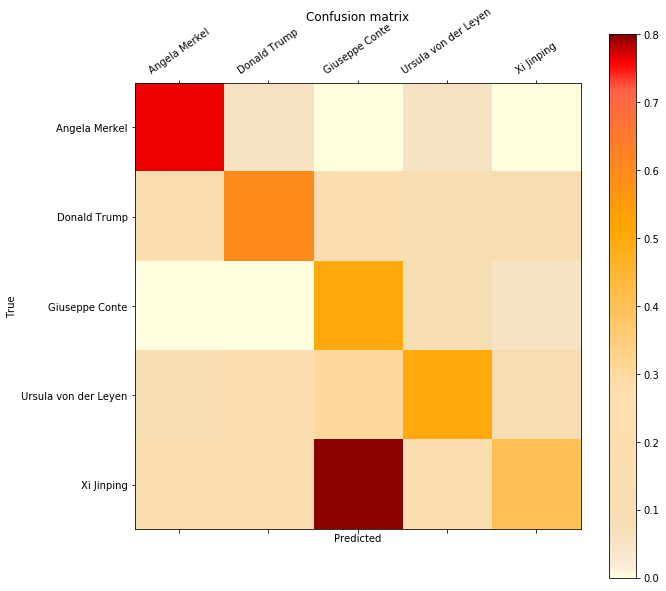

In [22]:
y_pred = clf.predict(X_test)

matrix(prediction=y_pred, tests=y_test, names=search_queries)

<font size=3>
    
La classificazione ottiene dei risultati peggiori rispetto al primo task, con un'accuratezza di $0.583$, che è comunque quasi il triplo di quello che raggiungerebbe in media il random guess.

## Riconoscimento con preprocessing

In [22]:
base_path = './downloads/'

X_train, X_test, y_train, y_test = load_data(feature_extractor=nn_inception, base_path=base_path, face_rec=True, prep=True)


X_train_stack = np.array([])
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))
    
eps = 0.001
X_train_mean = X_train_stack.mean()
X_train_std = X_train_stack.std()
X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]

In [23]:
np.save('face1_Xtrain_prepT.npy', X_train)
np.save('face1_Xtest_prepT.npy', X_test)

with open('face1_ytrain_prepT', 'wb') as yte:
    pickle.dump(y_train, yte)
with open('face1_ytest_prepT', 'wb') as ytr:
    pickle.dump(y_test, ytr)

In [23]:
X_train = np.load('face1_Xtrain_prepT.npy')
X_test = np.load('face1_Xtest_prepT.npy')

with open('face1_ytrain_prepT', 'rb') as yte:
    y_train = pickle.load(yte)
with open('face1_ytest_prepT', 'rb') as ytr:
    y_test = pickle.load(ytr)

In [24]:
param_grid = {'C': [30, 40, 50, 100],
              'gamma': [1e-5, 5e-5, 0.0001, 0.0005, 0.001]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=-1)

t1 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t1))

print("Migliore combinazione di parametri:")
print(" C: " + str(clf.best_estimator_.C))
print(" gamma: " + str(clf.best_estimator_.gamma))

c:\users\prowm\anaconda3\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 10.605s
Migliore combinazione di parametri:
 C: 40
 gamma: 0.0005


              precision    recall  f1-score   support

           0       0.65      0.87      0.74        15
           1       0.70      0.58      0.64        12
           2       0.50      0.58      0.54        12
           3       0.67      0.50      0.57        12
           4       0.57      0.44      0.50         9

   micro avg       0.62      0.62      0.62        60
   macro avg       0.62      0.60      0.60        60
weighted avg       0.62      0.62      0.61        60

Accuracy: 0.617

[[13  1  1  0  0]
 [ 5  7  0  0  0]
 [ 0  1  7  2  2]
 [ 2  0  3  6  1]
 [ 0  1  3  1  4]]


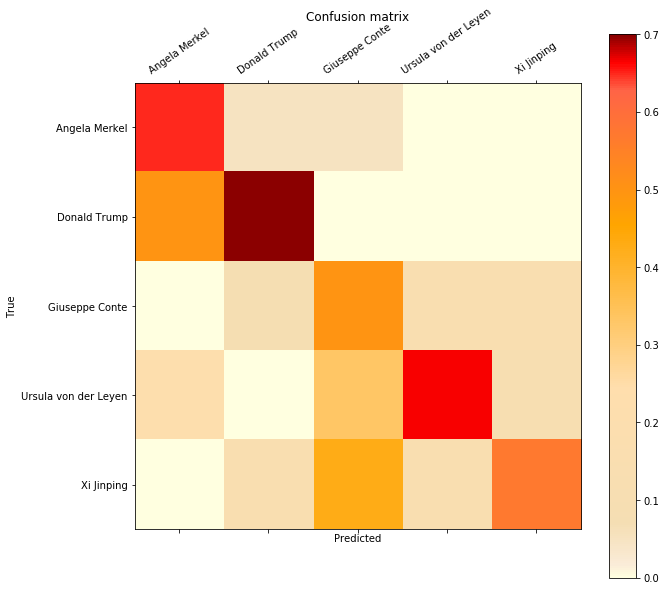

In [25]:
y_pred = clf.predict(X_test)

matrix(prediction=y_pred, tests=y_test, names=search_queries)

<font size=3>
    
Il preprocessing non migliora di molto le performance classificative; come nota positiva si può evidenziare il calo del tasso di misclassificazione fra <i>Giuseppe Conte</i> e <i>Xi Jinping</i>.
<br></br>

La presenza di alta variabilità intra-classe unita ad un maggior numero di categorie da classificare rende quasi impossibile raggiungere livelli di accuratezza simili a quelli del primo task.
Fra i possibili miglioramenti si potrebbero includere delle ulteriori tecniche di preprocessing, oppure l'utilizzo di una diversa tecnica di feature extraction, anche se <b>InceptionV3</b> è considerata una delle migliori reti per l'image recognition. <br> 